# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [307]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import math
import datetime

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [294]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%s] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        s = '%i\n%i' % (tree_root.ps.get(0, 0), tree_root.ps.get(1, 1))
        plt.text(x_center, y, s,
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def gini(x):
    vc = x.value_counts(normalize=True, sort=False)
    return (vc * (1-vc)).sum()
    
def entropy(x):
    vc = x.value_counts(normalize=True, sort=False)
    return -(vc * np.log2(vc)).sum()

def gain(left_y, right_y, criterion):
    n = left_y.size + right_y.size
    return criterion(left_y.append(right_y)) - criterion(left_y)*(left_y.size / n) - criterion(right_y)*(right_y.size / n)

class DecisionTreeLeaf:
    def __init__(self, y, ps):
        self.y = y
        self.ps = ps

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features='auto'):
        self.criterion = entropy if criterion == "entropy" else gini
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.probs = {}
        self.max_features = max_features
    
    def fit(self, xy):
        self.root = self.do_fit(xy, 0)
    
    def do_fit(self, xy, depth):
        y = xy['label']
        if y.size <= self.min_samples_leaf or depth == self.max_depth or y.unique().size == 1:
            ps = y.value_counts(sort=False)
            return DecisionTreeLeaf(0 if ps.size == 0 else ps.idxmax(), ps.to_dict())
        node_info = self.split(xy)
        left = self.do_fit(node_info['l'], depth+1)
        right = self.do_fit(node_info['r'], depth+1)
        return DecisionTreeNode(node_info['split_dim'], node_info['split_value'], left, right)
        
    def split(self, xy):
        node_info = {'g': None}
        features_number = math.ceil(math.sqrt(xy.columns.size))
        if self.max_features != 'auto':
            features_number = self.max_features
        for col in random.sample(xy.columns.to_list(), features_number):
            if col == 'label':
                continue
            m = xy[col].mean()
            l = xy[xy[col] < m]
            r = xy[xy[col] >= m]
            g = gain(l['label'], r['label'], self.criterion)
            if node_info['g'] is None or g > node_info['g']:
                node_info = {
                    'g': g,
                    'split_dim': col,
                    'split_value': m,
                    'l': l,
                    'r': r,
                }
        return node_info
    
    def predict_proba(self, X):
        self.probs = {}
        self.do_predict_proba(X, self.root)
        return list(map(lambda i: self.probs[i], X.index.to_list()))
    
    def do_predict_proba(self, X, node):
        if isinstance(node, DecisionTreeLeaf):
            for i in X.index:
                self.probs[i] = node.ps
        else:
            self.do_predict_proba(X[X[node.split_dim] < node.split_value], node.left)
            self.do_predict_proba(X[X[node.split_dim] >= node.split_value], node.right)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]        
        
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators
    
    def fit(self, X, y):
        self.xy = X.assign(label=y)
        self.trees = []
        self.oobs = []
        for i in range(self.n_estimators):
            t = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features)
            sample = self.xy.sample(frac=0.63, replace=False)
            self.oobs.append(self.xy.drop(labels=sample.index.unique().to_list()))
            t.fit(sample)
            self.trees.append(t)

    def predict_proba(self, X):
        df = pandas.DataFrame()
        for i in range(len(self.trees)):
            df['p_%i' % i] = self.trees[i].predict(X)
        return df.apply(lambda row: row.value_counts(normalize=True, sort=False).combine_first(pandas.Series([0, 0])), axis=1)
    
    def predict(self, X):
        return self.predict_proba(X).apply(lambda p: p.idxmax(), axis=1)
    
    def oob(self, j=None):
        n = len(self.trees)
        e = 0
        for i in range(n):
            if j is None:
                yp = self.trees[i].predict(self.oobs[i])
            else:
                col = self.oobs[i][j].sample(frac=1.0, replace=False)
                tmp = self.oobs[i].copy()
                tmp[j] = pandas.Series(col.to_list(), index=tmp.index)
                yp = self.trees[i].predict(tmp)
            e += 1 - np.mean(yp == self.oobs[i]['label'])
        return e/n

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [108]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pandas.read_csv(path_to_csv)
    return df.drop(['label'], axis=1), df['label'].apply(lambda t: 1 if t == 'M' else 0)

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pandas.read_csv(path_to_csv)
    return df.drop(['label'], axis=1), df['label']

def train_test_split(X, y, ratio):
    rows = random.sample(X.index.to_list(), round(ratio*len(X.index)))
    X_test = X.loc[rows]
    y_test = y.loc[rows]
    X_train = X.loc[~X.index.isin(rows)]
    y_train = y.loc[~y.index.isin(rows)]
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    return X_train, y_train, X_test, y_test

def oversampling(X, y):
    over = y.value_counts().idxmax()
    
    y_min = y[y != over]
    y_max = y[y == over]
    X_min = X.filter(y_min.index,axis = 0)
    X_max = X.filter(y_max.index,axis = 0)
    
    rows = random.choices(X_min.index.to_list(),k=len(y_max.index))
    X_over = X_min.loc[rows]
    y_over = y_min.loc[rows]
    
    X_over = pandas.concat([X_over, X_max])
    y_over = pandas.concat([y_over, y_max])
    
    # Возвращает данные, сбалансированные методом oversampling
    return X_over, y_over

CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'

X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

X_cancer_train_imb, y_cancer_train_imb, X_cancer_test, y_cancer_test = train_test_split(X_cancer, y_cancer, 0.85)
X_cancer_train, y_cancer_train = oversampling(X_cancer_train_imb, y_cancer_train_imb)

X_spam_train_imb, y_spam_train_imb, X_spam_test, y_spam_test = train_test_split(X_spam, y_spam, 0.9)
X_spam_train, y_spam_train = oversampling(X_spam_train_imb, y_spam_train_imb)

#### spam

In [162]:
forest = RandomForestClassifier(min_samples_leaf=10, max_depth=10, n_estimators=5)
%time forest.fit(X_spam_train, y_spam_train)
p_pred = forest.predict_proba(X_spam_test)
y_pred = p_pred.apply(lambda p: p.idxmax(), axis=1)
ppred = p_pred.apply(lambda p: p.to_dict(), axis=1)
print('AUC:', roc_auc_score(y_spam_test, p_pred[1]))

CPU times: user 7.5 s, sys: 7.78 ms, total: 7.51 s
Wall time: 7.49 s
AUC: 0.9465049937350217


accuracy_score: 0.9328664573774451


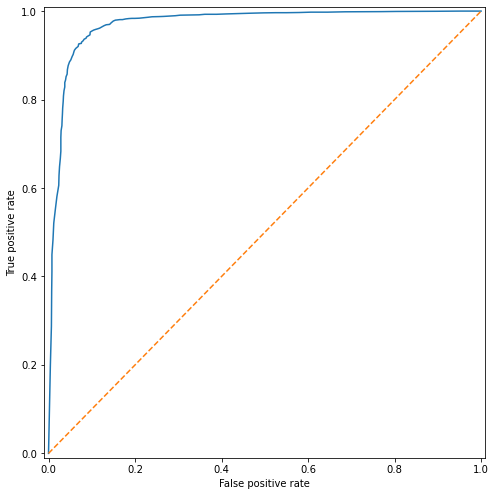

In [150]:
print('accuracy_score:', accuracy_score(y_spam_test, y_pred))
plot_roc_curve(y_spam_test, ppred)

#### cancer

CPU times: user 16.3 s, sys: 4.13 ms, total: 16.3 s
Wall time: 16.3 s
AUC: 0.9883595311402797
accuracy_score: 0.9545454545454546


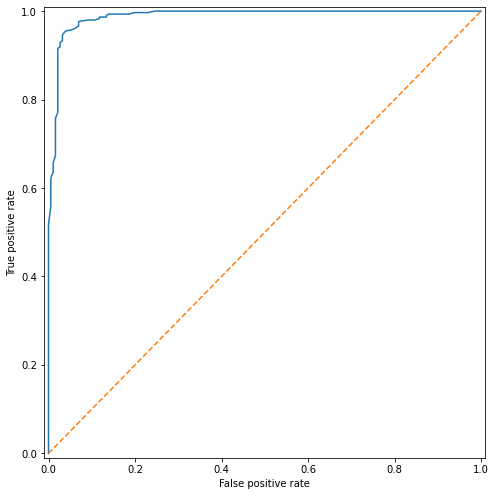

In [148]:
forest = RandomForestClassifier(min_samples_leaf=10, max_depth=3, n_estimators=100)
%time forest.fit(X_cancer_train, y_cancer_train)
p_pred = forest.predict_proba(X_cancer_test)
y_pred = p_pred.apply(lambda p: p.idxmax(), axis=1)
ppred = p_pred.apply(lambda p: p.to_dict(), axis=1)
print('AUC:', roc_auc_score(y_cancer_test, p_pred[1]))
print('accuracy_score:', accuracy_score(y_cancer_test, y_pred))
plot_roc_curve(y_cancer_test, ppred)

лучший результат для датасета cancer получен при max_depth=3, n_estimators=100;

лучший результат для датасета spam получен при max_depth=10, n_estimators=100;

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [299]:
def feature_importance(rfc):
    err_oob = rfc.oob()
    result = []
    for j in rfc.xy.columns.to_list()[:-1]:
        result.append((j, rfc.oob(j) - err_oob))
    return result

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [304]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X_, y_ = synthetic_dataset(1000)
X = pandas.DataFrame(X_)
y = pandas.Series(y_)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:")
importance = feature_importance(rfc)
importance.sort(key = lambda i: i[1])
for (k, v) in importance:
    print(k, v)

Accuracy: 1.0
Importance:
0 0.0
1 0.0
5 0.0
3 0.21218918918918928
2 0.21505405405405412
4 0.4027567567567567


Проверьте, какие признаки важны для датасетов cancer и spam?

In [302]:
rfc = RandomForestClassifier(min_samples_leaf=10, max_depth=3, n_estimators=100)
rfc.fit(X_cancer_train, y_cancer_train)
print("Importance:")
importance = feature_importance(rfc)
importance.sort(key = lambda i: i[1])
for (k, v) in importance:
    print(k, v)

Importance:
10 -0.0011692307692307558
9 -0.0008330895158481233
18 -0.0004924242424242109
17 -0.00045875935658545863
19 -0.0004347826086956441
2 -0.0003571428571428614
11 -0.0003333333333333244
30 -0.0002486772486772343
5 0.0
12 0.0
13 0.00037037037037036813
15 0.00037037037037036813
1 0.0010591133004926034
29 0.0012257878997009586
22 0.001467772967772965
20 0.0016484905898699054
25 0.00204349684132292
16 0.0022471047471047667
7 0.002847823463115823
6 0.004110218517115086
8 0.005763558391744292
14 0.007212788660614755
26 0.007903900952176815
3 0.009598209198209195
27 0.009679889908525585
4 0.010036862032963959
28 0.015556000601652784
23 0.019128855435751976
21 0.019435878092699685
24 0.019729755895543932


In [303]:
rfc = RandomForestClassifier(min_samples_leaf=10, max_depth=10, n_estimators=100)
rfc.fit(X_spam_train, y_spam_train)
print("Importance:")
importance = feature_importance(rfc)
importance.sort(key = lambda i: i[1])
for (k, v) in importance:
    print(k, v)

Importance:
word_freq_all -0.0004472834169569062
char_freq_: -3.106411873904369e-05
word_freq_3d 0.0
word_freq_parts 0.0
word_freq_cs 0.0
word_freq_table 0.0
char_freq_( 4.096776723053197e-05
word_freq_project 7.189207623509164e-05
word_freq_original 7.517292605002668e-05
word_freq_pm 7.87048942042512e-05
word_freq_415 0.00019985896003160697
word_freq_font 0.00020493813469488198
word_freq_technology 0.0002726773499709123
word_freq_857 0.00028351881346563856
word_freq_lab 0.00034256713844565967
word_freq_will 0.000405643329540184
word_freq_direct 0.0004154186100745194
word_freq_make 0.0005969088848077619
word_freq_conference 0.0007409112972326104
word_freq_telnet 0.000753628118479871
word_freq_addresses 0.00078732455960287
word_freq_people 0.0008231490506633021
char_freq_[ 0.0008267547201737113
char_freq_# 0.000861428382924051
word_freq_you 0.0010284584143587239
word_freq_internet 0.0010605661194573457
word_freq_re 0.0012474019290470428
word_freq_receive 0.0012813601198597702
word_freq_

#### ответ

для датасета cancer самые важные признаки 24, 21, 23

для датасета spam самые важные признаки char_freq_$, char_freq_!, word_freq_hp, word_freq_remove

### Задание 5 (2 балла)
В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов

In [305]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

     |████████████████████████████████| 2.0 MB 177 kB/s eta 0:00:01
     |████████████████████████████████| 67.3 MB 62 kB/s  eta 0:00:01     |█████████████████▏              | 36.1 MB 947 kB/s eta 0:00:33     |█████████████████▉              | 37.5 MB 2.3 MB/s eta 0:00:14     |███████████████████             | 39.8 MB 2.6 MB/s eta 0:00:11     |████████████████████▍           | 42.9 MB 3.3 MB/s eta 0:00:08     |███████████████████████████▉    | 58.5 MB 2.8 MB/s eta 0:00:04
     |████████████████████████████████| 13.2 MB 148 kB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=1c7d7d89f4ccf8b2caf0b0fcb193fbf56a62925bb6f91408f7555990ef7bb369
  Stored in directory: /home/boris/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying
     |████████████████████████████████| 157.5 MB 22 kB/s  eta 0:00:01    |███████████████▋                | 76.9 MB 3.2 MB/s eta 0:00:26     |███████████████▊ 

Также, как и реализованный нами RandomForest, примените модели для наших датасетов.

Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)). 

Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

CPU times: user 6.61 s, sys: 476 ms, total: 7.09 s
Wall time: 2.4 s
accuracy: 0.9504132231404959
AUC: 0.9876123084679235


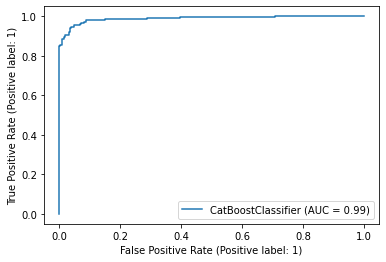

In [317]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=False)
# train the model
%time model.fit(X_cancer_train, y_cancer_train)
# make the prediction using the resulting model
preds_class = model.predict(X_cancer_test)
preds_proba = model.predict_proba(X_cancer_test)
print("accuracy:", accuracy_score(y_cancer_test, preds_class))
print("AUC:", roc_auc_score(y_cancer_test, preds_proba[:, 1]))
metrics.plot_roc_curve(model, X_cancer_test, y_cancer_test)  
plt.show()

CPU times: user 9.97 s, sys: 553 ms, total: 10.5 s
Wall time: 3.81 s
accuracy: 0.9306930693069307
AUC: 0.9761749571183534


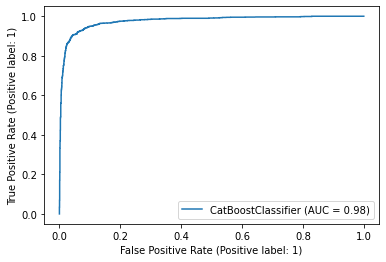

In [318]:
model = CatBoostClassifier(verbose=False)
# train the model
%time model.fit(X_spam_train, y_spam_train)
# make the prediction using the resulting model
preds_class = model.predict(X_spam_test)
preds_proba = model.predict_proba(X_spam_test)
print("accuracy:", accuracy_score(y_spam_test, preds_class))
print("AUC:", roc_auc_score(y_spam_test, preds_proba[:, 1]))
metrics.plot_roc_curve(model, X_spam_test, y_spam_test)  
plt.show()

[13:33:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 248 ms, sys: 458 µs, total: 248 ms
Wall time: 88.1 ms
accuracy: 0.9421487603305785
AUC: 0.9819226129386557


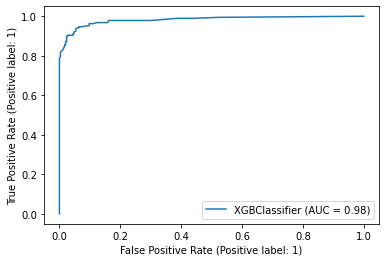

In [322]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False)
%time model.fit(X_cancer_train, y_cancer_train)
y_pred = model.predict(X_cancer_test)
preds_proba = model.predict_proba(X_cancer_test)
print("accuracy:", accuracy_score(y_cancer_test, y_pred))
print("AUC:", roc_auc_score(y_cancer_test, preds_proba[:, 1]))
metrics.plot_roc_curve(model, X_cancer_test, y_cancer_test)  
plt.show()

[14:04:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 637 ms, sys: 186 µs, total: 638 ms
Wall time: 188 ms
accuracy: 0.9154793528133301
AUC: 0.9648616230551197


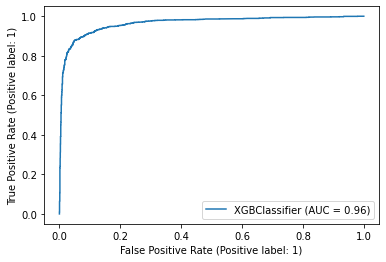

In [331]:
model = XGBClassifier(use_label_encoder=False)
x_train = X_spam_train.rename(columns=dict(zip(X_spam_train.columns.to_list(), range(X_spam_train.columns.size))))
x_test = X_spam_test.rename(columns=dict(zip(X_spam_test.columns.to_list(), range(X_spam_test.columns.size))))
%time model.fit(x_train, y_spam_train)
y_pred = model.predict(x_test)
preds_proba = model.predict_proba(x_test)
print("accuracy:", accuracy_score(y_spam_test, y_pred))
print("AUC:", roc_auc_score(y_spam_test, preds_proba[:, 1]))
metrics.plot_roc_curve(model, x_test, y_spam_test)  
plt.show()

CPU times: user 180 ms, sys: 3.2 ms, total: 184 ms
Wall time: 71.4 ms
accuracy: 0.9359504132231405
AUC: 0.9819676263526531


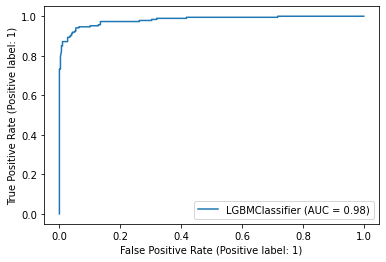

In [333]:
import lightgbm as lgb

model = lgb.LGBMClassifier()
%time model.fit(X_cancer_train, y_cancer_train)
y_pred = model.predict(X_cancer_test)
preds_proba = model.predict_proba(X_cancer_test)
print("accuracy:", accuracy_score(y_cancer_test, y_pred))
print("AUC:", roc_auc_score(y_cancer_test, preds_proba[:, 1]))
metrics.plot_roc_curve(model, X_cancer_test, y_cancer_test)  
plt.show()

CPU times: user 466 ms, sys: 0 ns, total: 466 ms
Wall time: 138 ms
accuracy: 0.9191016662641874
AUC: 0.9693303164118098


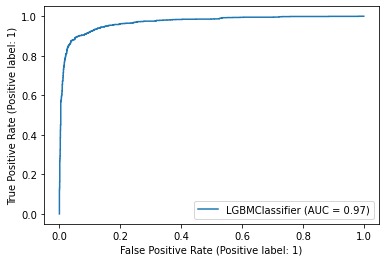

In [337]:
model = lgb.LGBMClassifier()
x_train = X_spam_train.rename(columns=dict(zip(X_spam_train.columns.to_list(), range(X_spam_train.columns.size))))
x_test = X_spam_test.rename(columns=dict(zip(X_spam_test.columns.to_list(), range(X_spam_test.columns.size))))
%time model.fit(x_train, y_spam_train)
y_pred = model.predict(x_test)
preds_proba = model.predict_proba(x_test)
print("accuracy:", accuracy_score(y_spam_test, y_pred))
print("AUC:", roc_auc_score(y_spam_test, preds_proba[:, 1]))
metrics.plot_roc_curve(model, x_test, y_spam_test)  
plt.show()

cancer:

лучшее accuracy = 0.955 дает RandomForestClassifier

лучшее AUC = 0.988 дают RandomForestClassifier и catboost.CatBoostClassifier

spam:

лучшее accuracy = 0.933 дает RandomForestClassifier

лучшее AUC = 0.976 дает catboost.CatBoostClassifier0.971 RandomForestClassifier

все библиотечные модели обучаются быстрее RandomForestClassifier на обоих датасетах

быстрее всех обучается lightgbm.LGBMClassifier при сопоставимых метриках